# DSMCER Notebook 11 - Neural Networks

1. Anatomy of a (basic) Neural Network
    1. Neurons, layers, networks
    2. Parameters of a Neuron, activation function
    3. _Poll_: Dimensionality of hidden layers
2. Backpropegation training
    1. The loss surface
    2. Training epochs, monitoring training
    3. _Poll_: Effect of standardization of backpropegation
    4. A basic example using very nonlinear features
    5. _Exercise_: Identify overfitting
3. Some neural network hyperparameters
    1. The neurons
    2. Regularization hyperparameters
    3. Optimization hyperparameters
    4. _Poll_: Advantages and disadvantages of NNs

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing

import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

# ! NEW
import torch

/opt/anaconda3/envs/DSMCER_general_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
***

## 1. Anatomy of a (basic) Neural Network

### A. Neurons, layers, networks

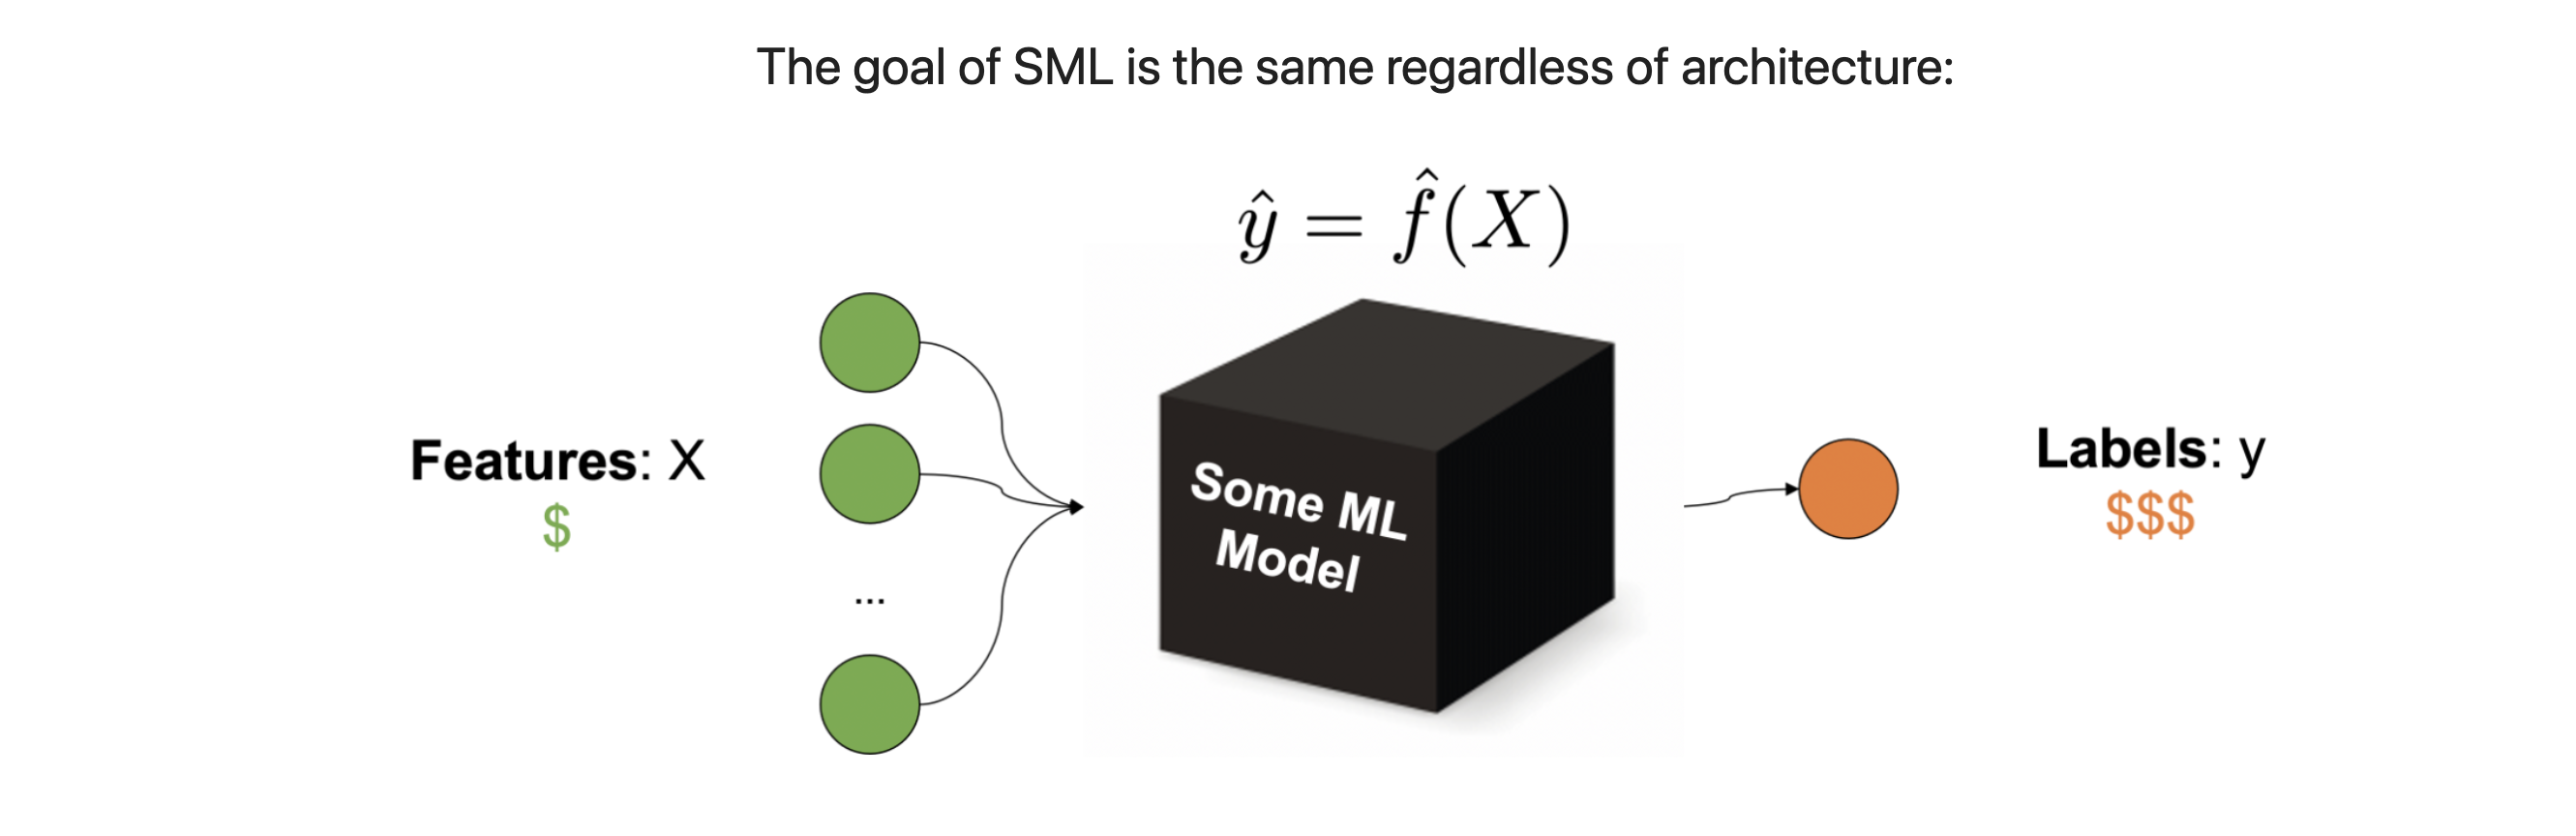

<font size=5><center> You may have heard of "Deep Learning" (eg. modeling with neural networks). __It is called deep because neural networks are highly nonlinear and extremely complex.__ They are made up of interconnected "neurons" stacked into "layers":

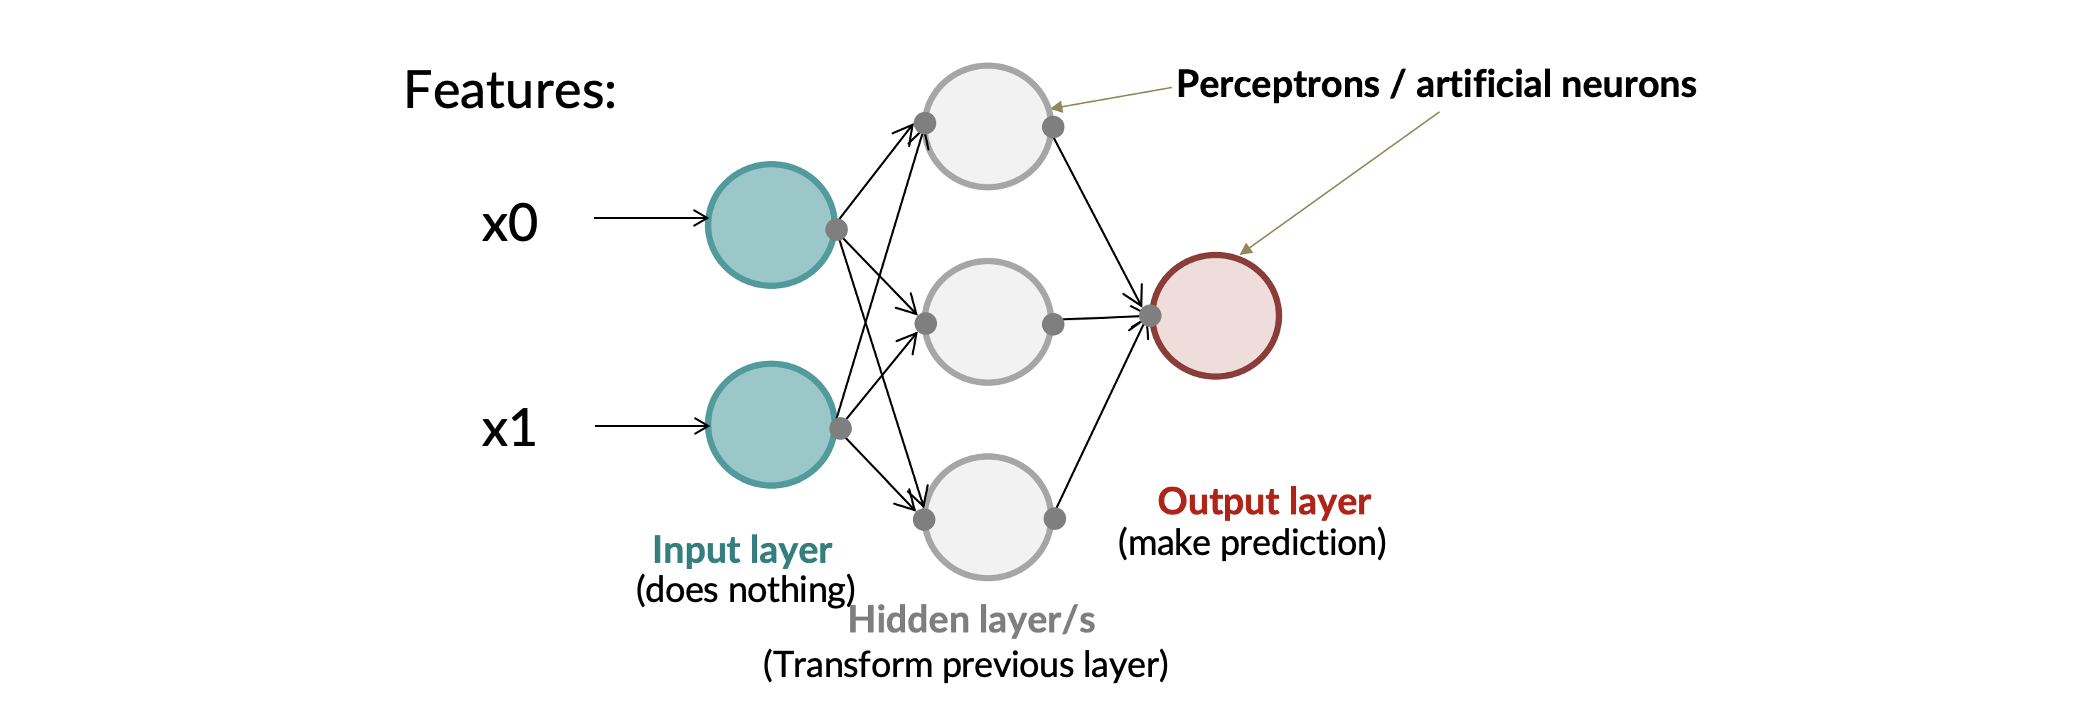

<font size=5><center>The data (X) __flows from left to right__ through the network (forward). At each step, mathematical transformations are conducted. The target is not involved yet (we will get to that).

***

<font size=4>So what are these "transformations"? Let's look at a single neuron:

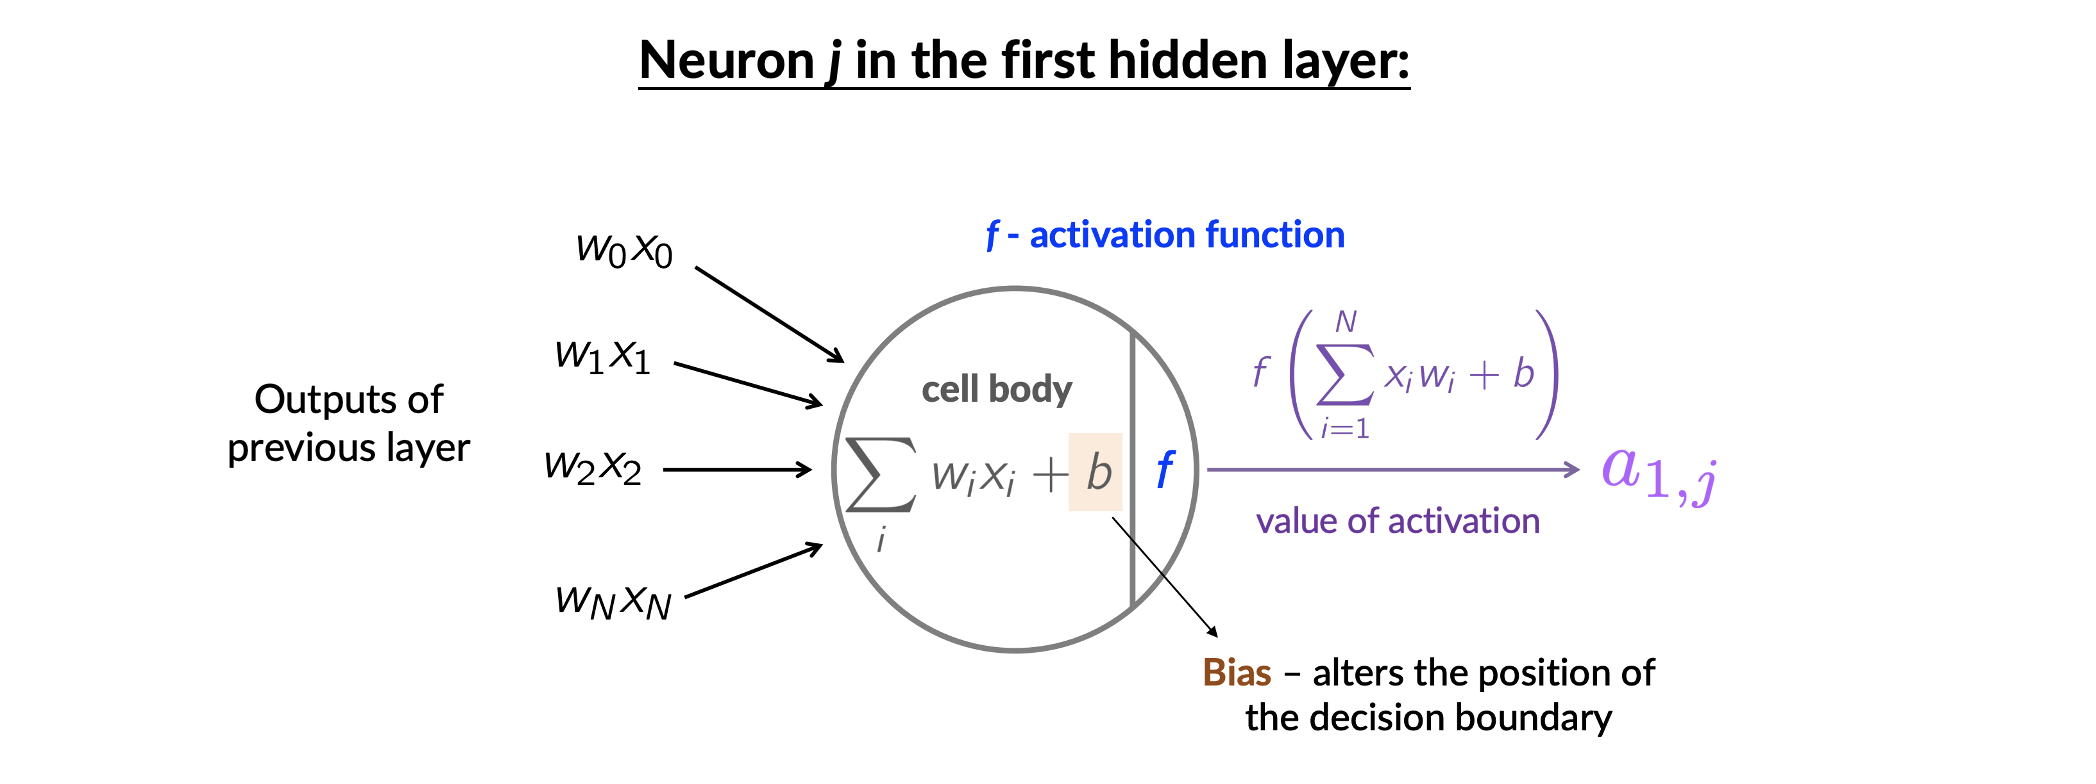

***

<font size=5><center>Activation functions are the source of the nonlinearity and happens as the last step of the neuron:

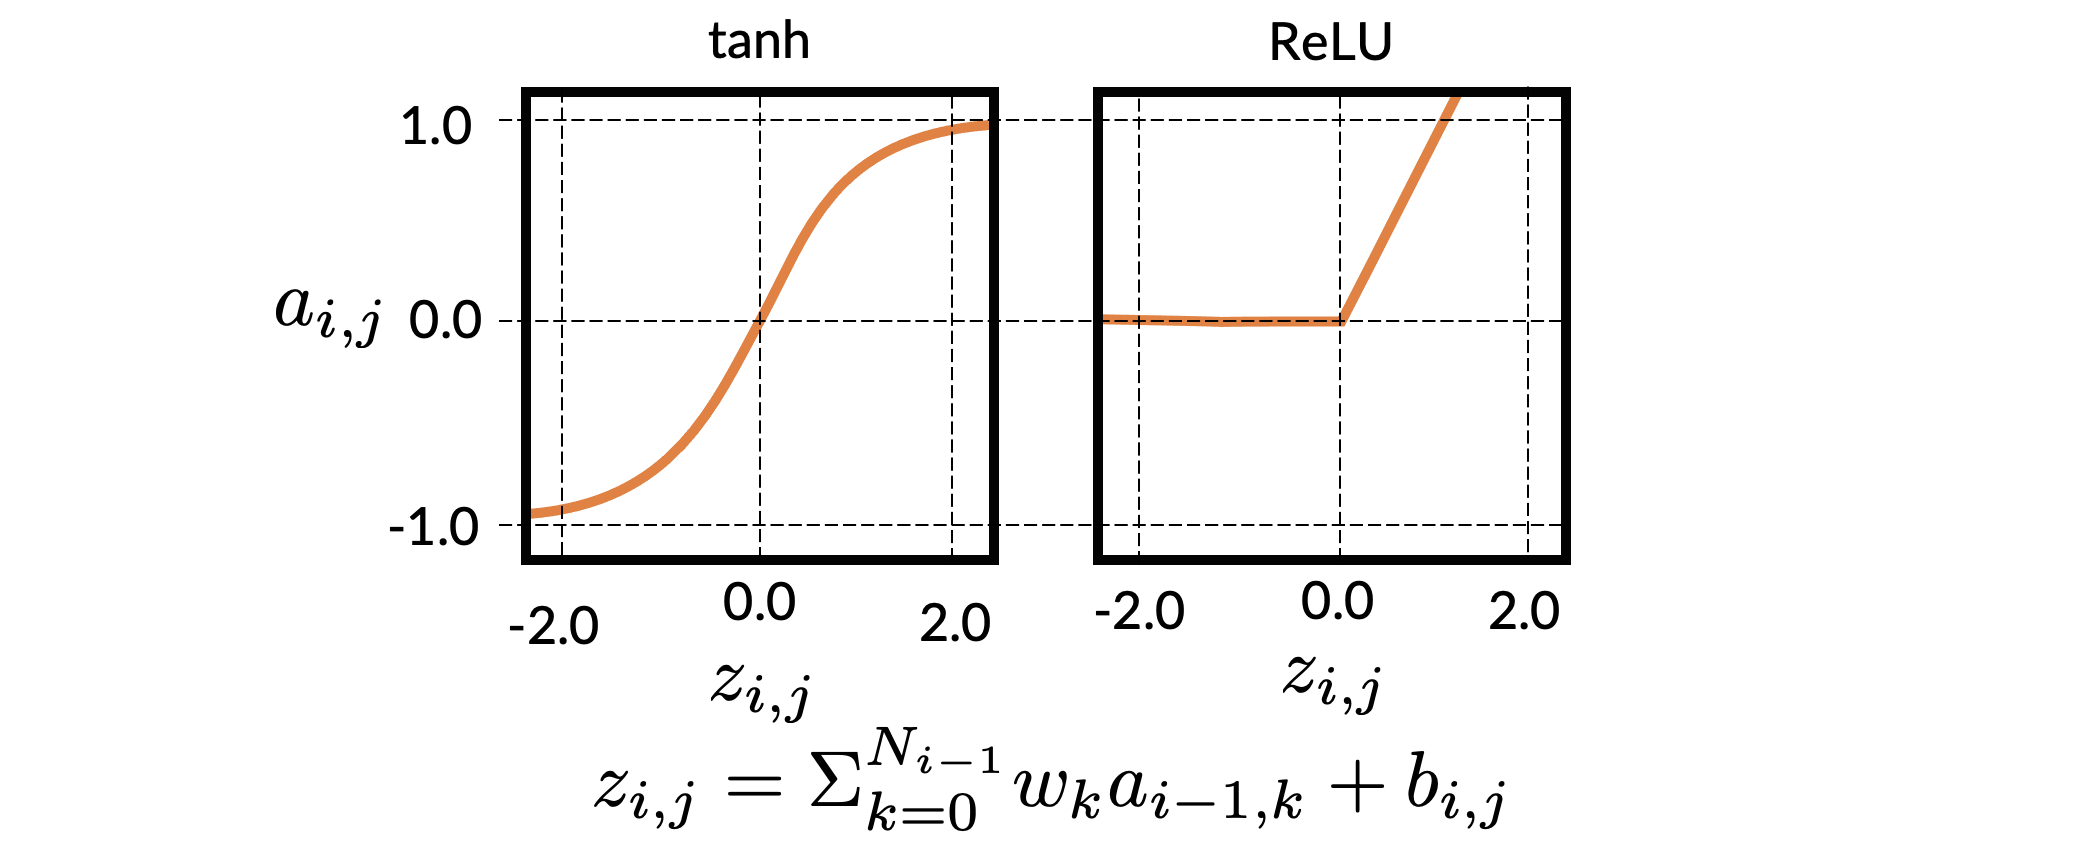

<font size=5><center>The activation function is a choice, there are many options.

***

### B. _Poll_: Dimensionality of hidden layers

<font size=4> Here, we have 3 input features, eg. the dimensionality of our features is 3. What is the dimensionality of our third hidden layer?

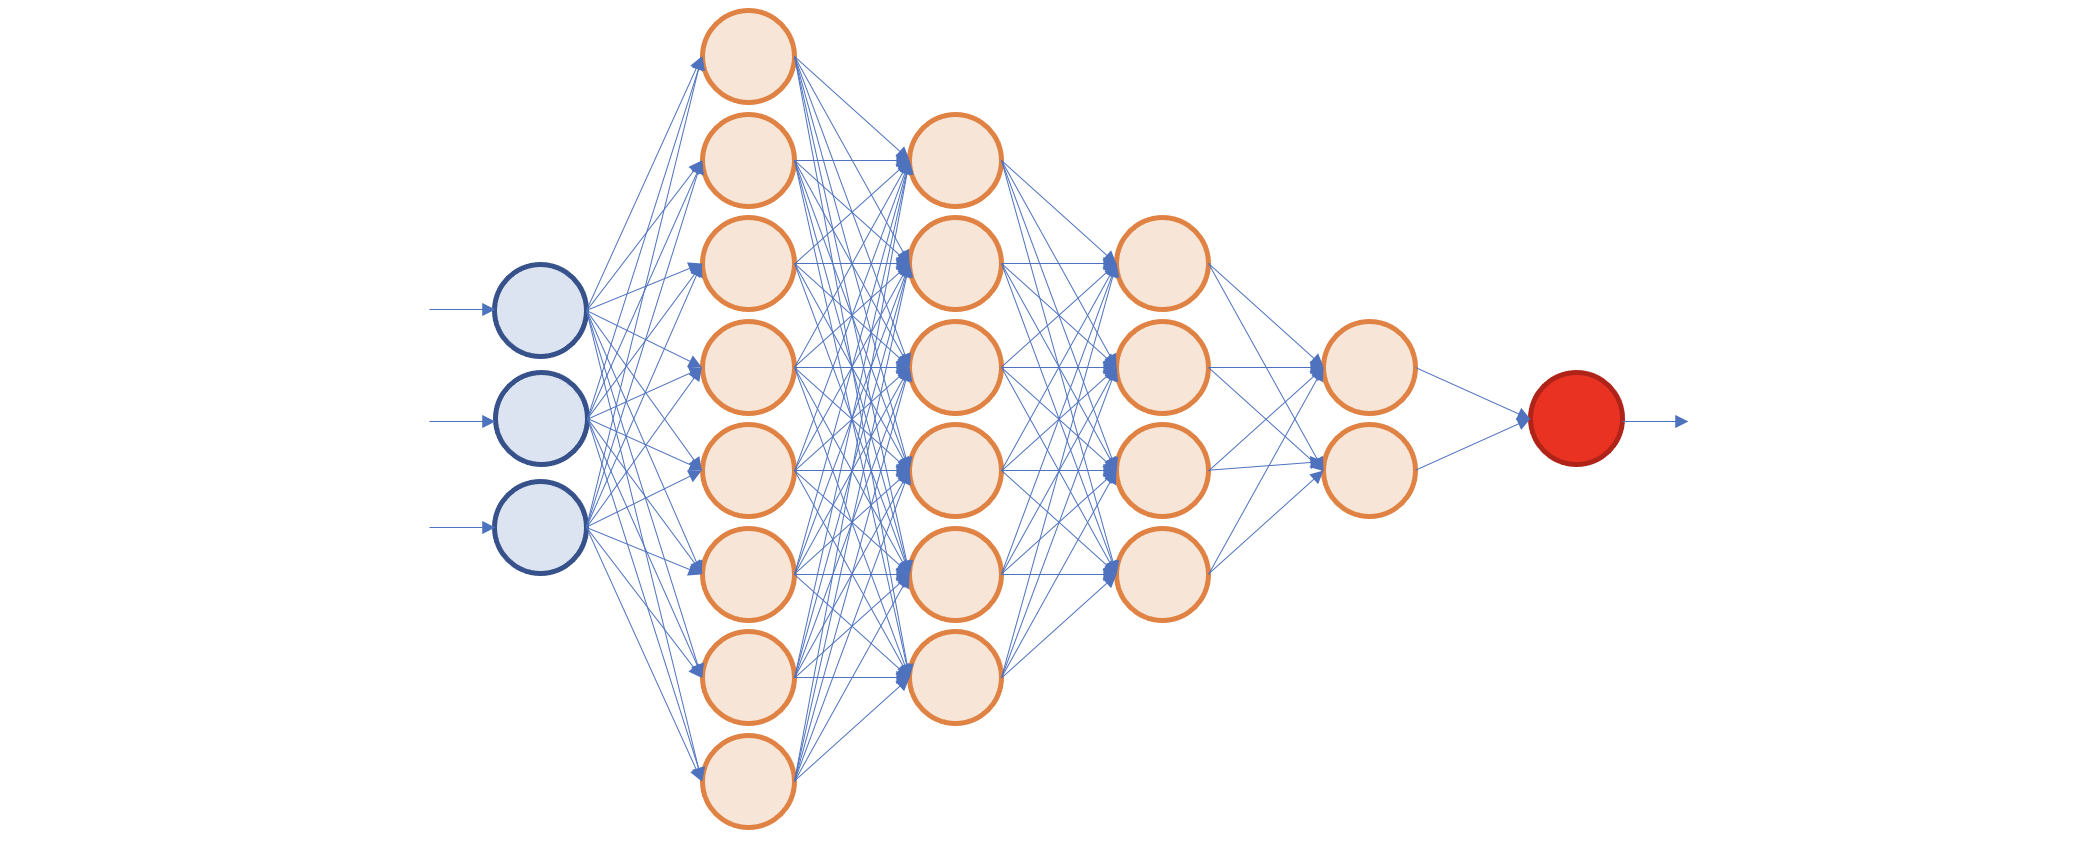

<font size=5><center>Each layer in the NN transforms the input into a new dimensional space.